In [1]:
from functions import *
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
global data

def read_data(filename):
    with h5py.File(filename, 'r') as f:
        molecules = ['H2', 'HeH+', 'HeHe']
        data = {mol: {
            'energies': f[mol]['energies'][:], 
            'bond_lengths': f[mol]['bond_lengths'][:],
            'alphas': f[mol]['alphas'][:],
            'cs': f[mol]['cs'][:],
        } 
            for mol in molecules}
    return data

In [3]:
def load_or_calculate_data(filename, data_key, calculation_func, *args):
    if os.path.exists(filename):
        print(f"Loading data from {filename}...")
        with h5py.File(filename, 'r') as h5f:
            return load_from_h5(h5f, data_key)
    else:
        print(f"{filename} not found. Running calculations and saving data...")
        data = [calculation_func(i, *args) for i in BOND_LENGTHS]
        with h5py.File(filename, 'w') as h5f:
            save_to_h5(h5f, data_key, data)
        print(f"All data saved to {filename}.")
        return data

In [54]:
def load_or_calculate_data(filename, data_key, calculation_func, *args):
    if os.path.exists(filename):
        print(f"Loading data from {filename}...")
        data = []
        basis_set = args[0]
        for basis in basis_set:
            with h5py.File(filename, 'r') as h5f:
                data.append(load_from_h5(h5f, f'{data_key}_{basis}'))
        return data
    else:
        print(f"{filename} not found. Running calculations and saving data...")
        data1 = [calculation_func(i, args[0][0], charge=args[1]) for i in BOND_LENGTHS]
        data2 = [calculation_func(i, args[0][1], charge=args[1]) for i in BOND_LENGTHS]
        data3 = [calculation_func(i, args[0][2], charge=args[1]) for i in BOND_LENGTHS]
        with h5py.File(filename, 'w') as h5f:
            save_to_h5(h5f, f'{data_key}_{args[0][0]}', data1)
            save_to_h5(h5f, f'{data_key}_{args[0][1]}', data2)
            save_to_h5(h5f, f'{data_key}_{args[0][2]}', data3)
        print(f"All data saved to {filename}.")
        return data1, data2, data3

In [55]:
def plot_data(x, data_list, labels, title, filename, ylim_top):
    plt.figure(figsize=(4.5, 4.7))
    style = {
        'HF/STO-3G': '-', 
        'HF/STO-6G': '-', 
        'HF/6-31G': '-', 
        'Standard 1s': '--', 
        'Optimized 1s': '-'
        }

    color = {
        'HF/STO-3G': 'red', 
        'HF/STO-6G': 'royalblue', 
        'HF/6-31G': 'green', 
        'Standard 1s': 'black', 
        'Optimized 1s': 'black'
        }
    for data, label in zip(data_list, labels):
        plt.plot(x, data, style[label], color=color[label], label=label)
    plt.legend(fontsize=12)
    plt.title(title)
    plt.xlabel(r"Bond Distance (Bohr)")
    plt.ylabel(r"Energy (Ha)")
    plt.xlim(right=5.0)
    plt.ylim(top=ylim_top)
    plt.tick_params(direction='in', top=True, right=True)
    plt.minorticks_on()
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


In [56]:
def HF_energy(R, basis='sto-3g', charge=False):
    mol = gto.Mole()
    mol.unit = 'bohr'
    mol.atom = 'H 0 0 0; H 0 0 ' + str(R)
    if charge:
        mol.charge = 2
        mol.atom = 'He 0 0 0; He 0 0 ' + str(R)
    mol.basis = basis
    mol.build()
    mf = scf.RHF(mol)
    mf.verbose = 0
    mf.kernel()
    return mf.e_tot

In [65]:
def HF_heh_p_energy(R, basis='sto-3g', charge=False):
    mol = gto.Mole()
    mol.unit = 'bohr'
    mol.atom = 'He 0 0 0; H 0 0 ' + str(R)
    mol.charge = 1
    mol.basis = basis
    mol.build()
    mf = scf.RHF(mol)
    mf.verbose = 0
    mf.kernel()
    return mf.e_tot


In [66]:
def save_to_h5(h5_file, group_name, data_list):
    grp = h5_file.create_group(group_name)
    grp.create_dataset('data', data=np.array(data_list))

def load_from_h5(h5_file, group_name):
    grp = h5_file[group_name]
    return grp['data'][:]

In [67]:
# Main execution
if os.path.exists('molecular_data.h5'):
    print("File exists. Skipping main execution.")
    data = read_data('molecular_data.h5')
else:
    main()
    data = read_data('molecular_data.h5')

File exists. Skipping main execution.


In [68]:
BOND_LENGTHS = data['H2']['bond_lengths']
x = np.round(np.arange(0.5, 5.01, 0.01), 2)

# Plotting settings
plt.rcParams.update({
    'text.usetex': True,
    'font.size': 14,
})


Loading data from h2_energy_data.h5...


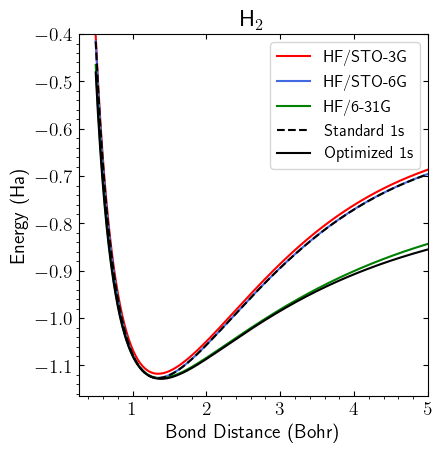

In [69]:
# H2 Plot
h2_sto3g, h2_sto6g, h2_321g = load_or_calculate_data(
    'h2_energy_data.h5', 
    'h2', 
    HF_energy, 
    ['sto-3g', 'sto-6g', '6-31g'], False
)

h2_1s_std = [h2_1s_energy(1.24, i, c=1) for i in BOND_LENGTHS]
h2_1s_opt = data['H2']['energies']

plot_data(x, [h2_sto3g, h2_sto6g, h2_321g, h2_1s_std, h2_1s_opt], 
          ['HF/STO-3G', 'HF/STO-6G', 'HF/6-31G', 'Standard 1s', 'Optimized 1s'], 
          r"H$_2$", 'h2.svg', -0.4)

Loading data from hehe_energy_data.h5...


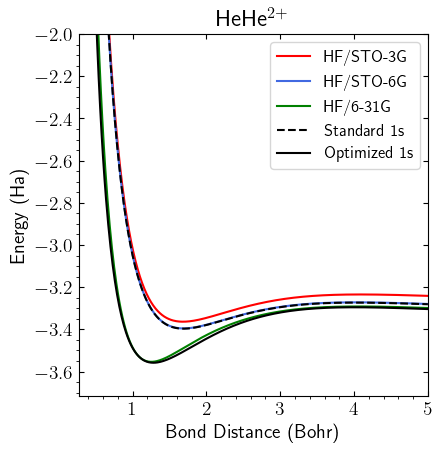

In [70]:
# HeHe Plot
hehe_sto3g, hehe_sto6g, hehe_321g = load_or_calculate_data(
    'hehe_energy_data.h5', 
    'hehe', 
    HF_energy, 
    ['sto-3g', 'sto-6g', '6-31g'], True
)

hehe_1s_std = [hehe_1s_energy(1.69, i, c=1) for i in BOND_LENGTHS]
hehe_1s_opt = data['HeHe']['energies']

plot_data(x, [hehe_sto3g, hehe_sto6g, hehe_321g, hehe_1s_std, hehe_1s_opt], 
          ['HF/STO-3G', 'HF/STO-6G', 'HF/6-31G', 'Standard 1s', 'Optimized 1s'], 
          r"HeHe$^{2+}$", 'hehe.svg', -2.0)

heh_p_energy_data.h5 not found. Running calculations and saving data...


All data saved to heh_p_energy_data.h5.


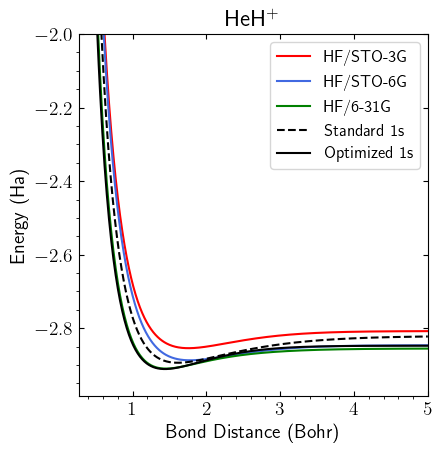

In [71]:
# HeH+ Plot
heh_p_sto3g, heh_p_sto6g, heh_p_321g = load_or_calculate_data(
    'heh_p_energy_data.h5', 
    'heh_p', 
    HF_heh_p_energy, 
    ['sto-3g', 'sto-6g', '6-31g'], False
)

heh_p_1s_std = [heh_1s_energy(1.7646, i, c=0.125) for i in x]
heh_p_1s_opt = data['HeH+']['energies']

plot_data(x, [heh_p_sto3g, heh_p_sto6g, heh_p_321g, heh_p_1s_std, heh_p_1s_opt], 
          ['HF/STO-3G', 'HF/STO-6G', 'HF/6-31G', 'Standard 1s', 'Optimized 1s'], 
          r"HeH$^{+}$", 'heh.svg', -2.0)
